# ACS2 in Cart Pole Environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import gym

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))

from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.metrics import population_metrics


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# papermill params
trials = 100_000
obs_adj_trials=1
bins = 6
decay=True
biased_exploration=0.05
do_ga=False

## Environment

In [3]:
env = gym.make('CartPole-v0')

Try some random steps to get min/max of each observation

In [4]:
%%time
print(f'Performing {obs_adj_trials} trials with random steps to collect ranges for observation points')

obs_arr = np.zeros((obs_adj_trials, 4))

for i in range(obs_adj_trials):
    env.reset()
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        obs_arr[i, :] = obs

env.close()

Performing 1 trials with random steps to collect ranges for observation points
CPU times: user 1.71 ms, sys: 985 µs, total: 2.7 ms
Wall time: 2.92 ms


For discretization calculate the range between variables

In [5]:
_high = obs_arr.max(axis=0)
_low = obs_arr.min(axis=0)

_range = _high - _low
_range

array([0., 0., 0., 0.])

## Agent configuration

In [6]:
class CartPoleAdapter(EnvironmentAdapter):
    BINS = bins
    
    @classmethod
    def to_genotype(cls, obs):
        return np.round(((obs - _low) / _range) * cls.BINS).astype(int).astype(str).tolist()

In [7]:
import math
# https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

# working (1, 1, 10, 14)
buckets = (5, 5, 8, 5)


class CartPoleAdapter2(EnvironmentAdapter):

    @classmethod
    def to_genotype(cls, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]

In [8]:
a = CartPoleAdapter2()
CartPoleAdapter2.to_genotype([0, 0, 0, 0])

['2', '2', '4', '2']

In [9]:
def print_cl(cl):
    actions = ['L', 'R']
    action = actions[cl.action]
    
    marked = ''
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [q: {cl.q:.3f}, fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}] {marked}")

## Evaluation metrics

In [10]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])

# collect more metrics
def cp_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

# ACS2 Configuration

In [11]:
cfg = Configuration(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=biased_exploration,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=do_ga,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=5,
            user_metrics_collector_fcn=cp_metrics,
            environment_adapter=CartPoleAdapter2)

# Experiments

In [12]:
print(f'Running {trials} trials, decay={decay}, bins={bins}\n')
print(cfg)

Running 100000 trials, decay=True, bins=6

{'classifier_length': 4, 'number_of_possible_actions': 2, 'classifier_wildcard': '#', 'environment_adapter': <class '__main__.CartPoleAdapter2'>, 'metrics_trial_frequency': 5, 'user_metrics_collector_fcn': <function cp_metrics at 0x114173b70>, 'do_pee': False, 'fitness_fcn': None, 'do_ga': False, 'do_subsumption': True, 'do_action_planning': False, 'action_planning_frequency': 50, 'theta_exp': 50, 'beta': 0.05, 'gamma': 0.99, 'theta_i': 0.1, 'theta_r': 0.9, 'epsilon': 0.95, 'biased_exploration': 0.05, 'u_max': 4, 'theta_ga': 50, 'theta_as': 20, 'mu': 0.03, 'chi': 0.8}


In [13]:
%%time

agent = ACS2(cfg)
population_explore, metrics_explore = agent.explore(env, trials, decay=decay)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 24, 'reward': 1.0, 'avg_fitness': nan, 'population': 17, 'numerosity': 17, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 38, 'reward': 1.0, 'avg_fitness': 6.674658356706271, 'population': 1567, 'numerosity': 1567, 'reliable': 104}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 18, 'reward': 1.0, 'avg_fitness': 6.601754370134197, 'population': 1975, 'numerosity': 1975, 'reliable': 141}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 24, 'reward': 1.0, 'avg_fitness': 6.880817121268903, 'population': 2254, 'numerosity': 2254, 'reliable': 177}
INFO:lcs.agen

CPU times: user 7h 43min 26s, sys: 29.9 s, total: 7h 43min 56s
Wall time: 7h 44min 38s


In [14]:
print(len(population_explore))

2794


In [15]:
for cl in sorted(population_explore, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

1033 - R - ###2 [q: 0.943, fit: 15.952, r: 16.92, ir: 1.00] 
1032 - L - ###3 [q: 0.949, fit: 15.762, r: 16.61, ir: 1.00] 
1#32 - L - ###3 [q: 0.924, fit: 15.356, r: 16.61, ir: 1.00] (*)
1042 - L - ###3 [q: 1.000, fit: 15.138, r: 15.14, ir: 1.00] 
1#33 - R - ###2 [q: 0.888, fit: 15.032, r: 16.92, ir: 1.00] (*)
1041 - L - ###2 [q: 1.000, fit: 14.771, r: 14.77, ir: 1.00] 
3242 - L - #1#3 [q: 0.998, fit: 14.660, r: 14.68, ir: 1.00] 
3442 - R - ###1 [q: 0.975, fit: 14.623, r: 14.99, ir: 1.00] 
#042 - L - ###3 [q: 1.000, fit: 14.512, r: 14.51, ir: 1.00] (*)
1#42 - L - ###3 [q: 0.941, fit: 14.249, r: 15.14, ir: 1.00] (*)
1141 - L - #0#2 [q: 0.965, fit: 14.031, r: 14.53, ir: 1.00] 
3143 - R - #2#2 [q: 0.942, fit: 13.795, r: 14.64, ir: 1.00] 
3440 - L - ###1 [q: 0.905, fit: 13.736, r: 15.17, ir: 1.00] 
1044 - R - ###3 [q: 0.971, fit: 13.536, r: 13.95, ir: 1.00] 
1431 - L - ###2 [q: 0.980, fit: 13.524, r: 13.81, ir: 1.00] 
3341 - L - #2#2 [q: 0.911, fit: 13.522, r: 14.84, ir: 1.00] 
3441 - L - #

In [16]:
metrics_df = pd.DataFrame(metrics_explore)
metrics_df.set_index('trial', inplace=True)

## Plots

In [17]:
# for plots
avg_window = int(trials/100)
figsize=(14,6)

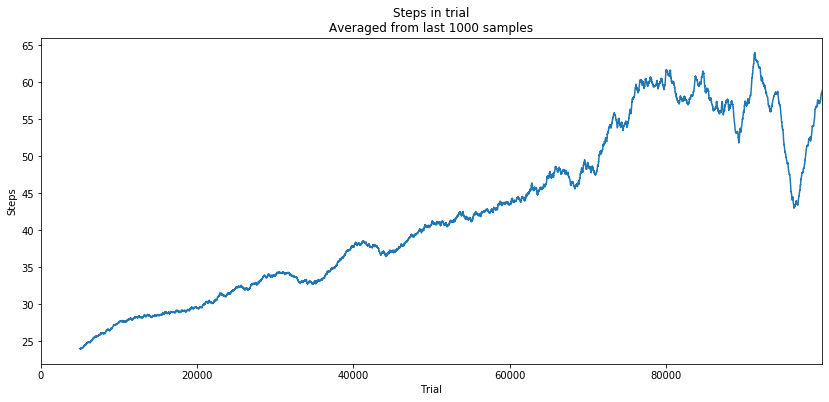

Avg steps 42.4224


In [18]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['steps_in_trial'].rolling(window=avg_window).mean().plot();
ax.set_title(f'Steps in trial\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Steps')

plt.show()

print(f"Avg steps {metrics_df['steps_in_trial'].mean()}")

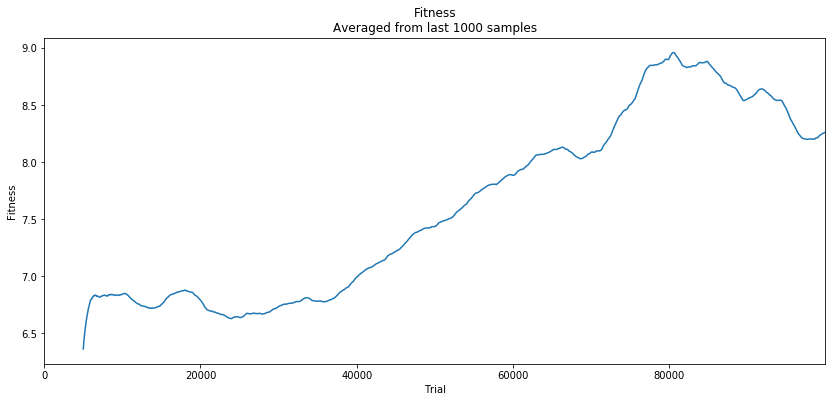

In [19]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['avg_fitness'].rolling(window=avg_window).mean().plot();
ax.set_title(f'Fitness\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Fitness')

plt.show()

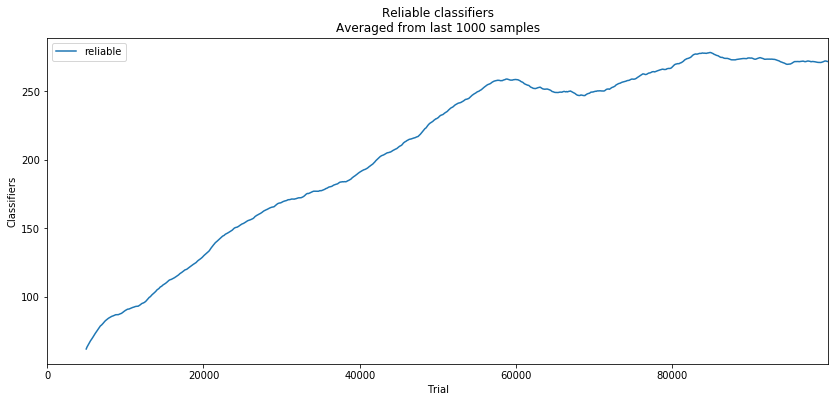

In [20]:
fig, ax = plt.subplots(figsize=figsize)

# metrics_df['population'].rolling(window=avg_window).mean().plot(label='population', ax=ax)
metrics_df['reliable'].rolling(window=avg_window).mean().plot(label='reliable', ax=ax)

ax.set_title(f'Reliable classifiers\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')

plt.legend()
plt.show()

## Exploitation

In [21]:
%%time

agent = ACS2(cfg, population_explore)
population_exploit, metrics_exploit = agent.exploit(env, 200)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 68, 'reward': 1.0, 'avg_fitness': 8.386963965524407, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.Agent:{'trial': 20, 'steps_in_trial': 39, 'reward': 1.0, 'avg_fitness': 8.348164906199587, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.Agent:{'trial': 40, 'steps_in_trial': 35, 'reward': 1.0, 'avg_fitness': 8.342947995842254, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.Agent:{'trial': 60, 'steps_in_trial': 23, 'reward': 1.0, 'avg_fitness': 8.333746004651832, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.Agent:{'trial': 80, 'steps_in_trial': 48, 'reward': 1.0, 'avg_fitness': 8.333191519604274, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 27, 'reward': 1.0, 'avg_fitness': 8.322380664215157, 'population': 2794, 'numerosity': 2794, 'reliable': 285}
INFO:lcs.agents.

CPU times: user 46.3 s, sys: 64.9 ms, total: 46.3 s
Wall time: 46.4 s


In [22]:
metrics_exploit_df = pd.DataFrame(metrics_exploit)
metrics_exploit_df.set_index('trial', inplace=True)

In [23]:
window = 5

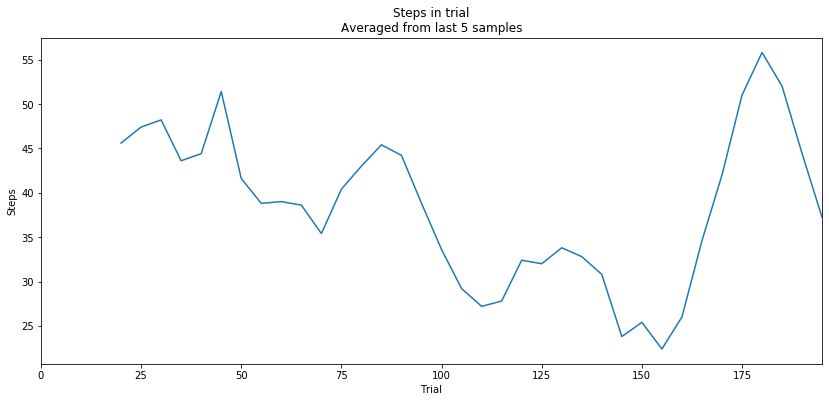

Avg steps 42.4224


In [24]:
fig, ax = plt.subplots(figsize=figsize)

metrics_exploit_df['steps_in_trial'].rolling(window=window).mean().plot();
ax.set_title(f'Steps in trial\nAveraged from last {window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Steps')

plt.show()

print(f"Avg steps {metrics_df['steps_in_trial'].mean()}")

In [25]:
for cl in sorted(population_exploit, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

1033 - R - ###2 [q: 0.943, fit: 15.952, r: 16.92, ir: 1.00] 
1032 - L - ###3 [q: 0.949, fit: 15.762, r: 16.61, ir: 1.00] 
1#32 - L - ###3 [q: 0.924, fit: 15.356, r: 16.61, ir: 1.00] (*)
1042 - L - ###3 [q: 1.000, fit: 15.138, r: 15.14, ir: 1.00] 
1#33 - R - ###2 [q: 0.888, fit: 15.032, r: 16.92, ir: 1.00] (*)
1041 - L - ###2 [q: 1.000, fit: 14.771, r: 14.77, ir: 1.00] 
3242 - L - #1#3 [q: 0.998, fit: 14.660, r: 14.68, ir: 1.00] 
3442 - R - ###1 [q: 0.975, fit: 14.623, r: 14.99, ir: 1.00] 
#042 - L - ###3 [q: 1.000, fit: 14.512, r: 14.51, ir: 1.00] (*)
1#42 - L - ###3 [q: 0.941, fit: 14.249, r: 15.14, ir: 1.00] (*)
1141 - L - #0#2 [q: 0.965, fit: 14.031, r: 14.53, ir: 1.00] 
3143 - R - #2#2 [q: 0.942, fit: 13.795, r: 14.64, ir: 1.00] 
3440 - L - ###1 [q: 0.905, fit: 13.736, r: 15.17, ir: 1.00] 
1044 - R - ###3 [q: 0.971, fit: 13.536, r: 13.95, ir: 1.00] 
1431 - L - ###2 [q: 0.980, fit: 13.524, r: 13.81, ir: 1.00] 
3341 - L - #2#2 [q: 0.911, fit: 13.522, r: 14.84, ir: 1.00] 
3441 - L - #